In [1]:
# Parameters
import json
with open("notebook_output_metadata.json") as f:
    metadata = json.load(f)
metadata

{'processed_s3_key': 'data/processed_data/phase4_pruned_all_latest_0445.csv',
 'timestamp': '0445'}

In [3]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import joblib
import mlflow
import shap
import warnings; warnings.filterwarnings("ignore")
import boto3
from io import BytesIO

In [4]:
project_root  = Path.cwd().parent
drv           = project_root/"data"/"derived"
data_fp       = drv/"phase4_pruned_all_latest.parquet"
features_fp   = drv/"feature_list.json"

In [5]:
# df = pd.read_parquet(data_fp)

try:
    processed_s3_key = metadata.get("processed_s3_key")
    print("Using processed data from metadata:", processed_s3_key)
except (FileNotFoundError, json.JSONDecodeError, KeyError):
    processed_s3_key = None
    print("No valid metadata found. Falling back to latest phase4_* file.")

# --- Load data from S3 ---
bucket = "verikai-heart-risk-pipeline"
s3 = boto3.client("s3")

if processed_s3_key:
    key = processed_s3_key
    print("Loading from S3 key:", key)
else:
    # Fallback: find the latest phase4_*.csv
    prefix = "data/processed_data/"
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    phase4_keys = sorted(
        [obj["Key"] for obj in response.get("Contents", [])
         if obj["Key"].startswith(prefix + "phase4_") and obj["Key"].endswith(".csv")],
        reverse=True
    )
    if not phase4_keys:
        raise FileNotFoundError("No phase4_*.csv files found in S3.")
    key = phase4_keys[0]
    print("Fallback: Latest phase4 file on S3:", key)

# --- Read CSV from S3 ---
df = pd.read_csv(BytesIO(s3.get_object(Bucket=bucket, Key=key)["Body"].read()))


with open(features_fp) as f:
    feature_list = json.load(f)

Using processed data from metadata: data/processed_data/phase4_pruned_all_latest_0445.csv
Loading from S3 key: data/processed_data/phase4_pruned_all_latest_0445.csv


In [8]:
df.head()

,age_group,sex,income,marital_status,race_ethnicity,smoked_100_cigs,current_smoker_flag,recent_exercise,meets_activity_guidelines,heavy_drinker,...,physical_unhealthy_days_bin_code,bmi_bin_code,bmi_missing,bmi_log_missing,alcohol_days_clean_missing,alcohol_days_clean_log_missing,mental_unhealthy_days_log_missing,physical_unhealthy_days_log_missing,income_missing,high_cholesterol_missing
0,13.0,Female,8.0,Married,White,0.0,1.0,0.0,0.0,0.0,...,0.0,3.0,0,0,1,0,0,0,0,0
1,13.0,Female,8.0,Divorced,White,0.0,1.0,1.0,1.0,0.0,...,0.0,2.0,0,0,1,0,0,0,0,0
2,13.0,Female,2.0,Widowed,Black,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0,0,1,0,0,0,0,0
3,12.0,Female,8.0,Married,White,0.0,1.0,1.0,1.0,0.0,...,1.0,2.0,0,0,1,0,0,0,0,0
4,12.0,Female,8.0,Widowed,White,0.0,1.0,1.0,1.0,0.0,...,0.0,2.0,0,0,0,0,0,0,0,0


In [20]:
X = df[feature_list]       
y = df["heart_attack"]

In [22]:
num_cols = ["bmi_log_z", "physical_unhealthy_days_log_z"]
cat_cols = [c for c in feature_list if c not in num_cols]

In [24]:
for col in cat_cols:
    if df[col].dropna().nunique() <= 2 and df[col].dtype == "float64":
        df[col] = df[col].astype("Int64")  

for col in cat_cols:
    if df[col].dtype == "object":
        df[col] = df[col].astype("category")
print(df[cat_cols].dtypes)

age_group                               float64
sex                                    category
income                                  float64
marital_status                         category
race_ethnicity                         category
smoked_100_cigs                           Int64
current_smoker_flag                       Int64
recent_exercise                           Int64
meets_activity_guidelines                 Int64
heavy_drinker                             Int64
has_health_insurance                      Int64
prev_chd_or_mi                            Int64
skin_cancer                               Int64
other_cancer                              Int64
asthma                                    Int64
high_bp_flag                              Int64
taking_bp_meds                            Int64
stroke                                    Int64
high_cholesterol                          Int64
chol_check_recent                       float64
ever_depression_dx                      

In [26]:
#keeping ordinal structure for modeling (recommended baseline)
ordinal_features = ["age_group", "income", 
                    "bmi_bin_code", 
                    "mental_unhealthy_days_bin_code", 
                    "physical_unhealthy_days_bin_code"]
df[ordinal_features] = df[ordinal_features].astype("Int64")
num_cols = ["bmi_log_z", "physical_unhealthy_days_log_z"] + ordinal_features
cat_cols = [col for col in feature_list if col not in num_cols]
df[cat_cols].dtypes

sex                                    category
marital_status                         category
race_ethnicity                         category
smoked_100_cigs                           Int64
current_smoker_flag                       Int64
recent_exercise                           Int64
meets_activity_guidelines                 Int64
heavy_drinker                             Int64
has_health_insurance                      Int64
prev_chd_or_mi                            Int64
skin_cancer                               Int64
other_cancer                              Int64
asthma                                    Int64
high_bp_flag                              Int64
taking_bp_meds                            Int64
stroke                                    Int64
high_cholesterol                          Int64
chol_check_recent                       float64
ever_depression_dx                        Int64
general_health                         category
difficulty_walking                      

In [28]:
from sklearn.impute import SimpleImputer
def train_pipeline(X, y, cat_cols, num_cols, best_params=None,
                   model_name="xgb_model", save_path=None):
    print(f"\n Training model: {model_name}")

    #Fallback to default params if not provided
    if best_params is None:
        best_params = {
            "n_estimators": 100,
            "max_depth": 4,
            "learning_rate": 0.1,
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "random_state": 42,
            "n_jobs": -1
        }
    else:
        best_params.setdefault("use_label_encoder", False)
        best_params.setdefault("eval_metric", "logloss")
        best_params.setdefault("random_state", 42)
        best_params.setdefault("n_jobs", -1)

    #Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42)

    #Preprocessing

    num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", "passthrough") 
    ])

    preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", num_pipe, num_cols)
    ])

    #Model pipeline
    clf = XGBClassifier(**best_params)
    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)

    #Evaluation
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n AUROC: {auc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    RocCurveDisplay.from_predictions(y_test, y_pred_proba)
    plt.title(f"{model_name} ROC Curve")
    plt.show()

    if save_path:
        joblib.dump(pipe, save_path)
        print(f" Model saved to: {save_path}")
    return pipe, X_test, y_test, y_pred


 Training model: xgb_baseline

 AUROC: 0.9884
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     81461
           1       0.66      0.98      0.79      4690

    accuracy                           0.97     86151
   macro avg       0.83      0.98      0.89     86151
weighted avg       0.98      0.97      0.97     86151

Confusion Matrix:
 [[79044  2417]
 [   82  4608]]


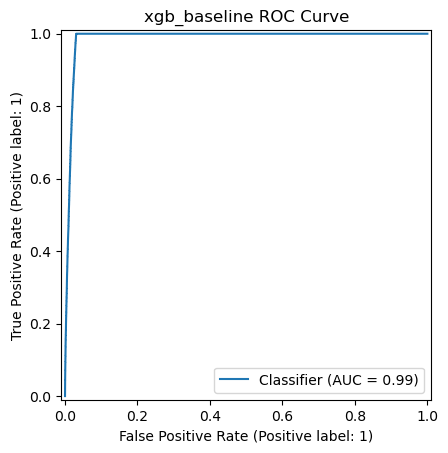

 Model saved to: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/models/xgb_baseline.joblib


In [30]:
import os
project_root = Path(os.getcwd()).parent 
model_dir=project_root / "models" 
pipe_best, X_test, y_test, y_pred = train_pipeline(
    X=X,
    y=y,
    cat_cols=cat_cols,
    num_cols=num_cols,
    best_params=None,  
    model_name="xgb_baseline",
    save_path=model_dir / "xgb_baseline.joblib"
)

In [32]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
# Sampling 30 % of data once for the search for lighter compute on my machine
_, X_tune, _, y_tune = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 300, step=50),
        "max_depth":    trial.suggest_int("max_depth", 3, 6),
        "learning_rate":trial.suggest_float("learning_rate", 0.03, 0.2, log=True),
        "subsample":    trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 4.0),
        "eval_metric": "logloss",
        "random_state": 42,
        "use_label_encoder": False,
    }
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", "passthrough")
    ])

    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", num_pipe, num_cols)
    ])

    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", XGBClassifier(**params))
    ])
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc = cross_val_score(pipe, X_tune, y_tune,
                          cv=cv, scoring="roc_auc",
                          n_jobs=1, error_score="raise").mean()
    return 1 - auc

study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=5, show_progress_bar=True)


[I 2025-05-09 15:53:19,383] A new study created in memory with name: no-name-c4827cde-df24-4f91-974e-6dc0b2b3199c


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-05-09 15:54:37,714] Trial 0 finished with value: 0.011776467295974147 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.04540512876577922, 'subsample': 0.7393322256902526, 'colsample_bytree': 0.8830669867709268, 'scale_pos_weight': 1.2274356228311345}. Best is trial 0 with value: 0.011776467295974147.
[I 2025-05-09 15:56:14,428] Trial 1 finished with value: 0.012104360952381654 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.10524495478456194, 'subsample': 0.8979800582080886, 'colsample_bytree': 0.8907068692401754, 'scale_pos_weight': 1.282611199582767}. Best is trial 0 with value: 0.011776467295974147.
[I 2025-05-09 15:57:38,737] Trial 2 finished with value: 0.012018397496061706 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.08709875882059344, 'subsample': 0.8475601943312312, 'colsample_bytree': 0.9292083942581609, 'scale_pos_weight': 3.7020086898800657}. Best is trial 0 with value: 0.011776467295974147.

In [34]:
best_score  = 1 - study.best_value        
best_params = study.best_params

print(f"Best AUROC: {best_score:.4f}")
print("Best hyper‑parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Best AUROC: 0.9882
Best hyper‑parameters:
  n_estimators: 150
  max_depth: 5
  learning_rate: 0.04540512876577922
  subsample: 0.7393322256902526
  colsample_bytree: 0.8830669867709268
  scale_pos_weight: 1.2274356228311345



 Training model: xgb_tuned_optuna

 AUROC: 0.9885
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     81461
           1       0.65      1.00      0.79      4690

    accuracy                           0.97     86151
   macro avg       0.83      0.98      0.89     86151
weighted avg       0.98      0.97      0.97     86151

Confusion Matrix:
 [[78969  2492]
 [   13  4677]]


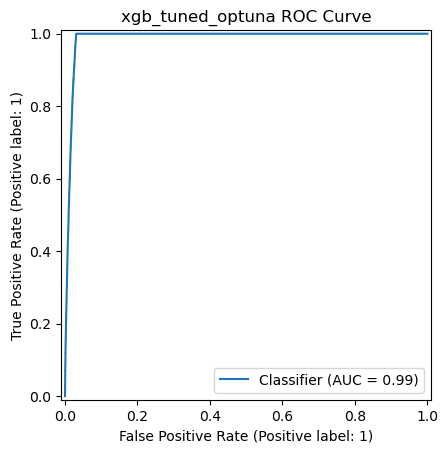

 Model saved to: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/models/xgb_tuned_optuna.joblib


In [36]:
pipe_tuned, X_test, y_test, y_pred  = train_pipeline(
    X=X,
    y=y,
    cat_cols=cat_cols,
    num_cols=num_cols,
    best_params=best_params,  #from Optuna
    model_name="xgb_tuned_optuna",
    save_path=model_dir / "xgb_tuned_optuna.joblib"
)

In [36]:
# project_root  = Path.cwd().parent
# model_dir=project_root / "models" 
# model_path = model_dir / "xgb_tuned_optuna.joblib"
# pipe_tuned = joblib.load(model_path)

In [38]:
# import shap
# import matplotlib.pyplot as plt
# from pathlib import Path

def explain_shap(model_pipeline, X_test, save_dir, prefix="shap"):
    """
    Generates and saves SHAP bar and beeswarm plots from a trained pipeline.
    
    Args:
        model_pipeline: Trained scikit-learn pipeline with 'pre' and 'clf' steps
        X_test: Original test set (before transformation)
        save_dir: Directory path to save plots
        prefix: Filename prefix for saved plots
    """
    print("Generating SHAP summary plots ")

    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Extract preprocessor and model
    model = model_pipeline.named_steps["clf"]
    preprocessor = model_pipeline.named_steps["pre"]
    
    # Transform input
    X_trans = preprocessor.transform(X_test)

    # Get feature names after transform
    cat_features = preprocessor.transformers_[0][2]
    num_features = preprocessor.transformers_[1][2]
    encoded_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
    final_feature_names = list(encoded_cat) + num_features

    # Compute SHAP values
    explainer = shap.Explainer(model)
    shap_vals = explainer(X_trans)

    # Bar plot
    shap.summary_plot(shap_vals, features=X_trans, feature_names=final_feature_names,
                      plot_type="bar", show=False)
    plt.savefig(save_dir / f"{prefix}_summary_bar.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()
   

    # Beeswarm
    shap.summary_plot(shap_vals, features=X_trans, feature_names=final_feature_names,
                      show=False)
    plt.savefig(save_dir / f"{prefix}_summary_beeswarm.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()

    print("SHAP plots saved to:", save_dir)

    return shap_vals, final_feature_names

 Generating SHAP summary plots...


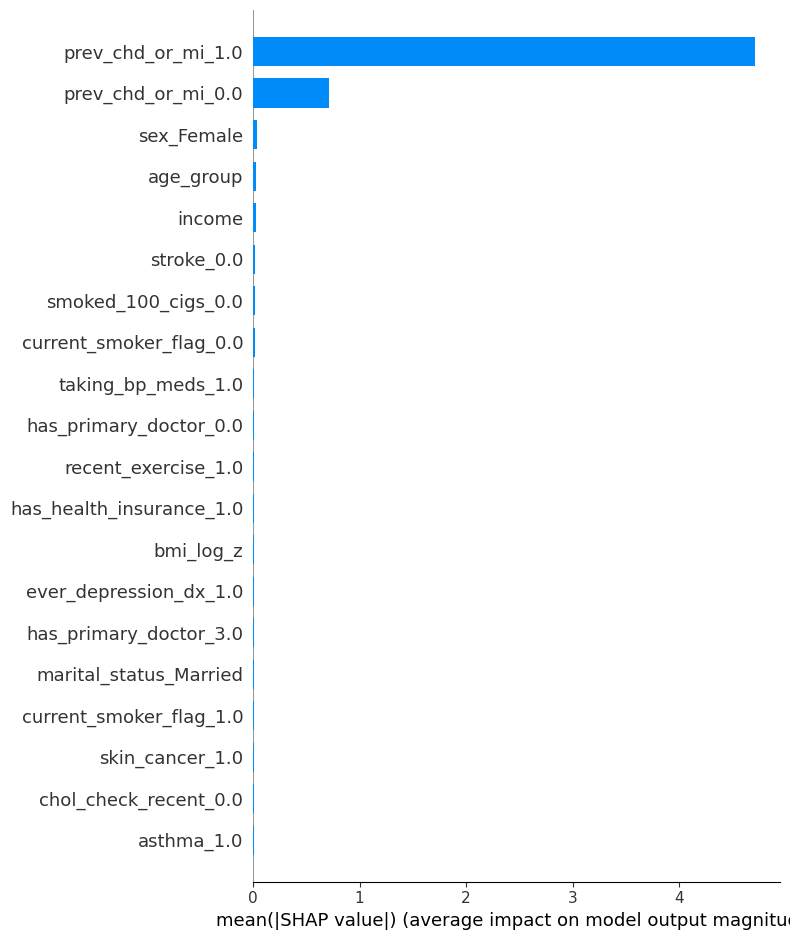

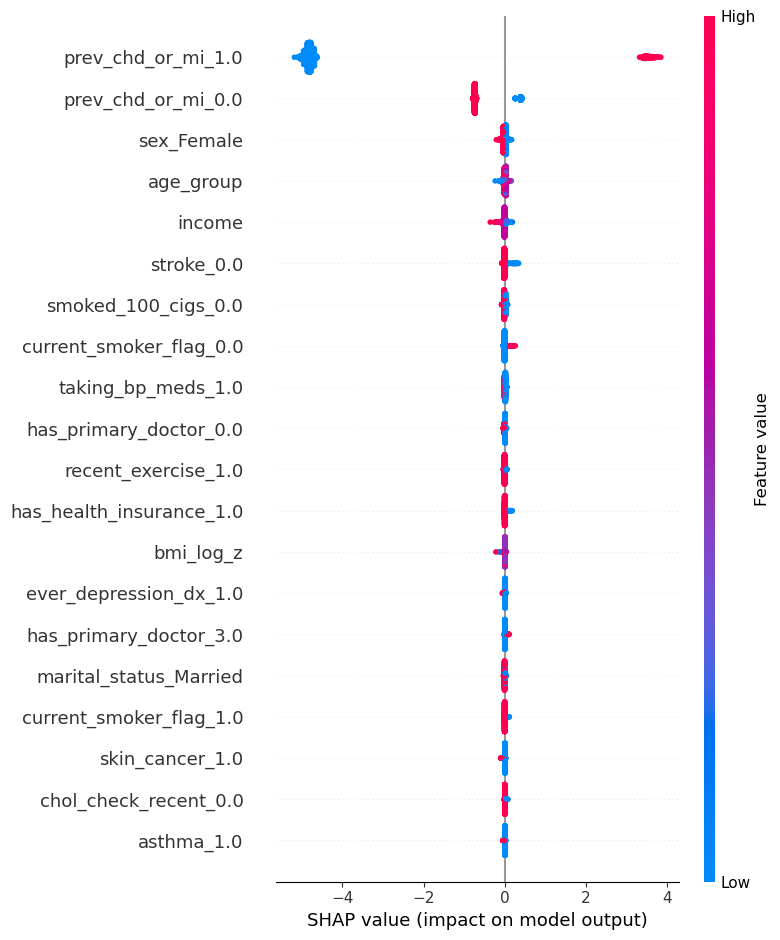

 SHAP plots saved to: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/reports/phase5


<Figure size 640x480 with 0 Axes>

In [40]:
report_dir = project_root / "reports" / "phase5"
X_shap = X_test.sample(n=2000, random_state=42)

shap_vals_tuned, final_feature_names = explain_shap(
    model_pipeline=pipe_tuned,
    X_test=X_shap,
    save_dir=report_dir,
    prefix="shap_tuned_optuna"
)


 SHAP Waterfall – True Positive (index 15)


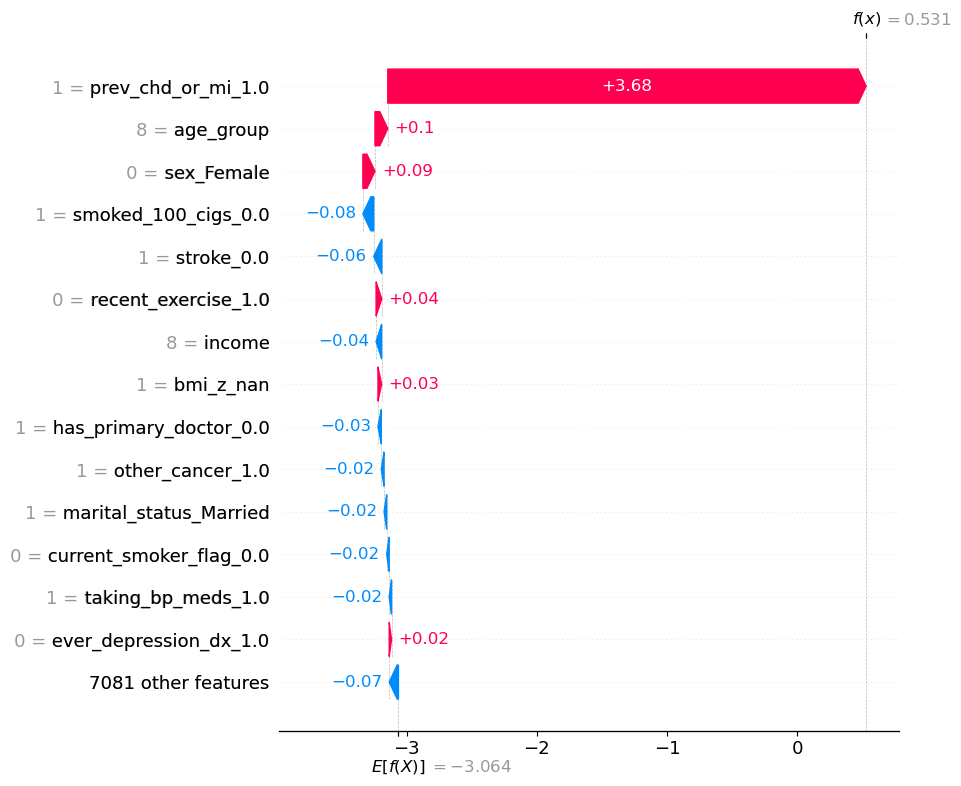


 SHAP Waterfall – False Negative (index 580)


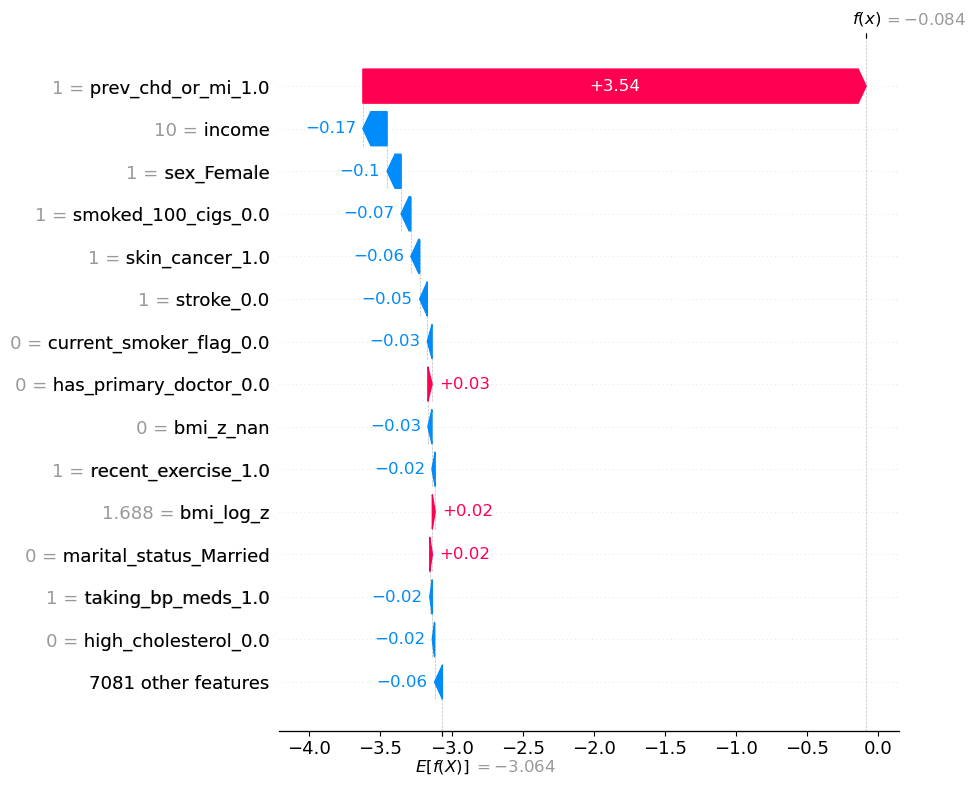


 SHAP Waterfall – Random Example (index 66582)


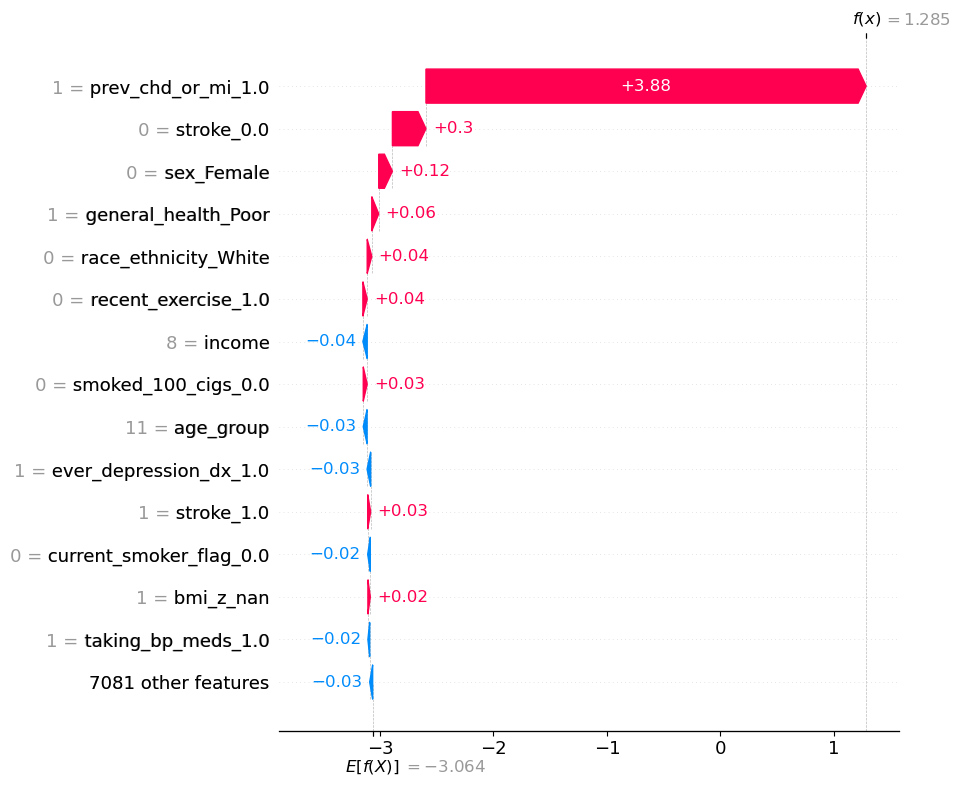

<Figure size 640x480 with 0 Axes>

In [42]:
# CM
tp_idx = np.where((y_test == 1) & (y_pred == 1))[0]
fn_idx = np.where((y_test == 1) & (y_pred == 0))[0]
rand_idx = np.random.choice(len(y_test), 1)[0]

ex_idx_tp = tp_idx[0] if len(tp_idx) else None
ex_idx_fn = fn_idx[0] if len(fn_idx) else None
ex_idx_rand = rand_idx

# Recomputing SHAP explainer with transform
explainer = shap.Explainer(pipe_best.named_steps["clf"])
X_trans = pipe_best.named_steps["pre"].transform(X_test)
raw_shap_vals = explainer(X_trans)

# Injecting actual names into SHAP Explanation
shap_vals = shap.Explanation(
    values=raw_shap_vals.values,
    base_values=raw_shap_vals.base_values,
    data=raw_shap_vals.data,
    feature_names=final_feature_names
)

# Plot: True Positive 
if ex_idx_tp is not None:
    print(f"\n SHAP Waterfall – True Positive (index {ex_idx_tp})")
    shap.plots.waterfall(shap_vals[ex_idx_tp], max_display=15)

# Plot: False Negative 
if ex_idx_fn is not None:
    print(f"\n SHAP Waterfall – False Negative (index {ex_idx_fn})")
    shap.plots.waterfall(shap_vals[ex_idx_fn], max_display=15)

# Plot: Random Case
print(f"\n SHAP Waterfall – Random Example (index {ex_idx_rand})")
shap.plots.waterfall(shap_vals[ex_idx_rand], max_display=15)
plt.savefig(report_dir / f"shap_waterfall_tp_{ex_idx_tp}.png", dpi=300, bbox_inches="tight")

In [48]:
# print("False Negatives:", len(fn_idx))

False Negatives: 84


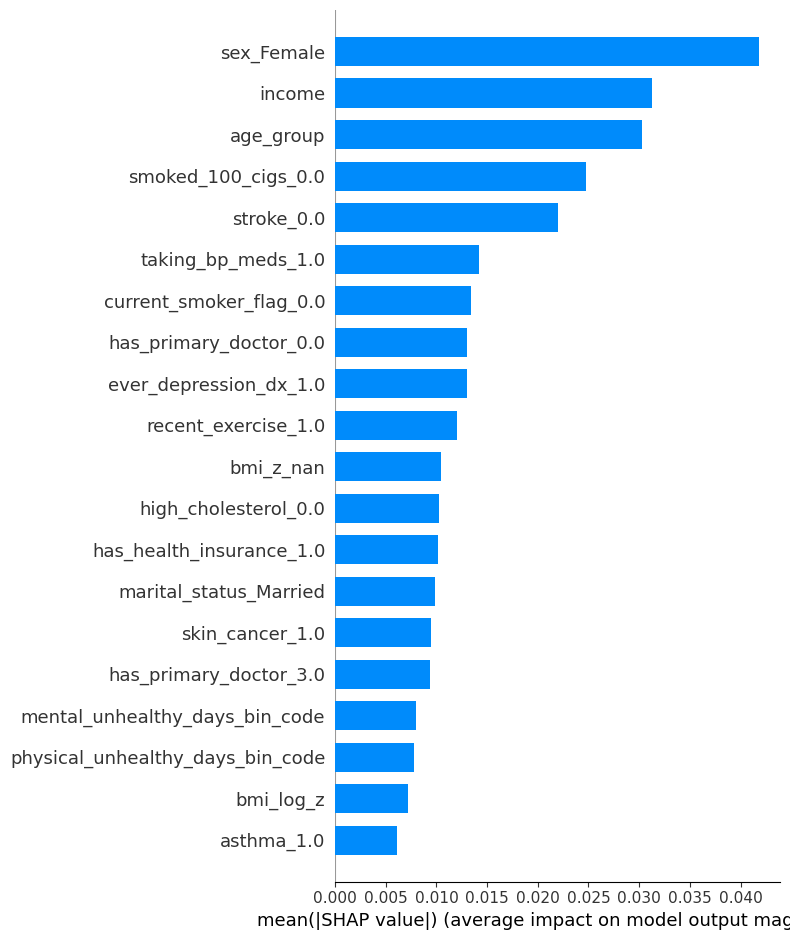

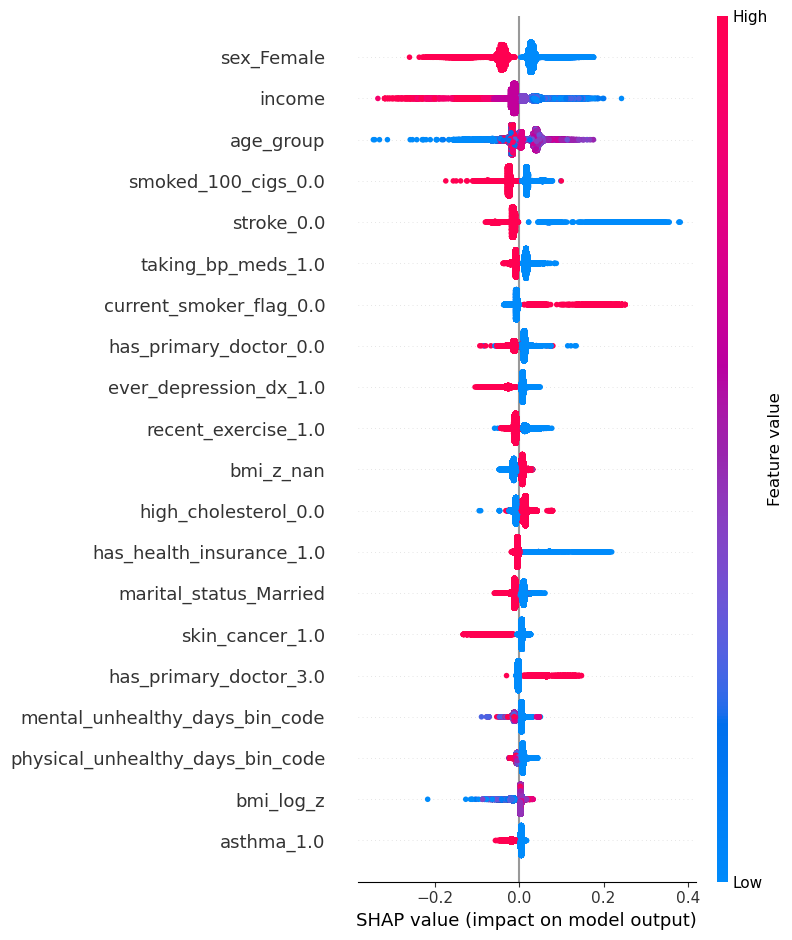

In [44]:
shap_df = pd.DataFrame(shap_vals.values, columns=shap_vals.feature_names)

# Filter out diagnosis-related features
exclude_features = ["prev_chd_or_mi_1.0", "prev_chd_or_mi_0.0"]
keep_cols = [col for col in shap_df.columns if col not in exclude_features]

# Subset SHAP values
filtered_vals = shap_vals[:, [i for i, name in enumerate(shap_vals.feature_names) if name in keep_cols]]
shap.summary_plot(filtered_vals, feature_names=keep_cols, plot_type="bar")
shap.summary_plot(filtered_vals, feature_names=keep_cols)

# Feature Engineering

In [46]:
import pandas as pd

def feature_engineering(df):
    df = df.copy()
    
    # High-risk combo features ---
    combo_flags = ["prev_chd_or_mi", "smoked_100_cigs", "high_bp_flag", "stroke", "taking_bp_meds"]
    if all(col in df.columns for col in combo_flags):
        df["high_risk_combo_sum"] = df[combo_flags].sum(axis=1)
        df["high_risk_cluster_2plus"] = (df["high_risk_combo_sum"] >= 2).astype("int64")

    # Legacy interaction features ---
    if "bmi_log_z" in df.columns and "physical_unhealthy_days_log_z" in df.columns:
        df["bmi_x_phys_unhealthy"] = df["bmi_log_z"] * df["physical_unhealthy_days_log_z"]

    if "smoked_100_cigs" in df.columns and "age_group" in df.columns:
        df["smoker_age_risk"] = df["smoked_100_cigs"] * df["age_group"]

    #Chronic burden score ---
    chronic_flags = ["asthma", "stroke", "high_bp_flag", "skin_cancer", "other_cancer"]
    available_chronic = [col for col in chronic_flags if col in df.columns]
    df["chronic_burden"] = df[available_chronic].sum(axis=1)

    # Preventive neglect flag ---
    if "has_primary_doctor" in df.columns and "chol_check_recent" in df.columns:
        df["preventive_neglect"] = (
            (df["has_primary_doctor"] == 0) & (df["chol_check_recent"] == 0)
        ).astype("int64")

    #BMI bucketed risk ---
    if "bmi" in df.columns:
        df["bmi_risk_category"] = pd.cut(
            df["bmi"],
            bins=[0, 18.5, 24.9, 29.9, 100],
            labels=["underweight", "normal", "overweight", "obese"]
        )
        # Numeric code version (optional for modeling)
        df["bmi_risk_code"] = df["bmi_risk_category"].cat.codes.replace(-1, pd.NA)

    return df

In [51]:
df = feature_engineering(df)
data_dir = project_root / "data" / "derived"
# Create/Update feature list
new_features = [
    "high_risk_combo_sum", "high_risk_cluster_2plus",
    "bmi_x_phys_unhealthy", "smoker_age_risk",
    "chronic_burden", "preventive_neglect",
    "bmi_risk_code"
]

with open(data_dir / "feature_list.json") as f:
    base_features = json.load(f)

final_features = base_features + [f for f in new_features if f in df.columns]

with open(data_dir / "feature_list_with_engineering.json", "w") as f:
    json.dump(final_features, f, indent=2)


In [53]:
X = df[final_features]
y = df["heart_attack"]

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["number"]).columns.difference(cat_cols).tolist()



 Training model: xgb_with_engineering_v2

 AUROC: 0.9884
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     81461
           1       0.65      0.99      0.79      4690

    accuracy                           0.97     86151
   macro avg       0.83      0.98      0.89     86151
weighted avg       0.98      0.97      0.97     86151

Confusion Matrix:
 [[78985  2476]
 [   33  4657]]


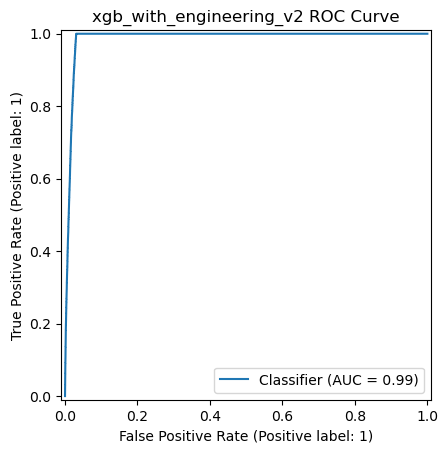

 Model saved to: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/models/xgb_with_engineering_v2.joblib


In [55]:
pipe_eng, X_test, y_test, y_pred = train_pipeline(
    X=X,
    y=y,
    cat_cols=cat_cols,
    num_cols=num_cols,
    best_params=best_params,  # or None if doing baseline
    model_name="xgb_with_engineering_v2",
    save_path=model_dir / "xgb_with_engineering_v2.joblib"
)

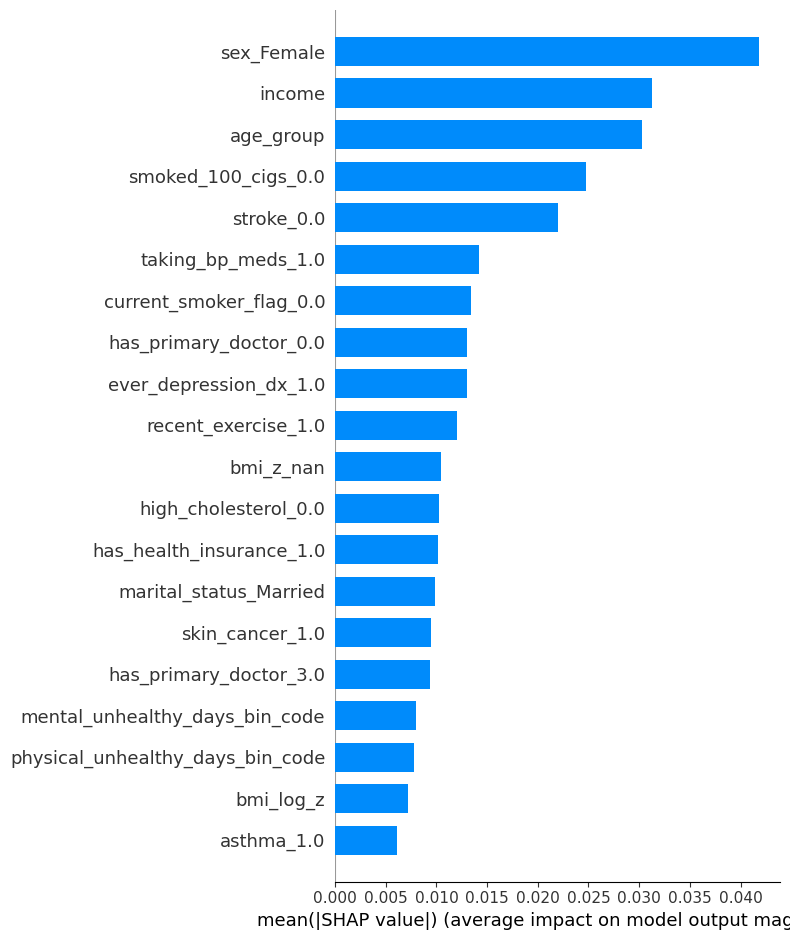

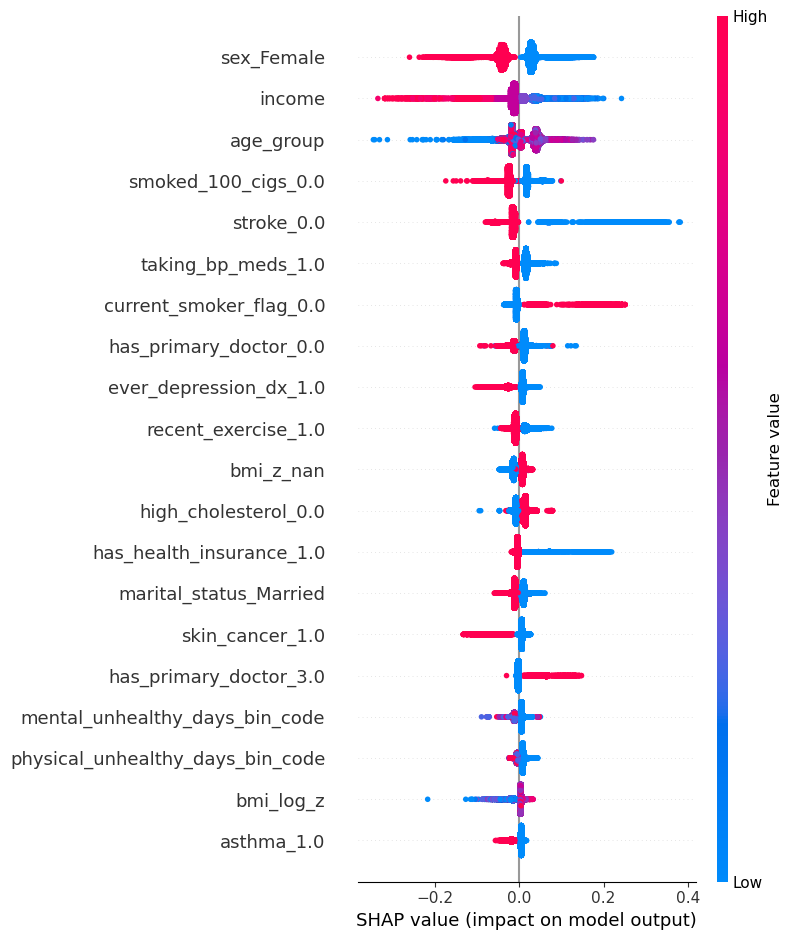

<Figure size 640x480 with 0 Axes>

In [57]:
exclude_feat = "prev_chd_or_mi"
mask = [exclude_feat not in f for f in final_feature_names]

filtered_shap = shap.Explanation(
    values=shap_vals.values[:, mask],
    base_values=shap_vals.base_values,
    data=shap_vals.data[:, mask],
    feature_names=[f for f in final_feature_names if exclude_feat not in f]
)

shap.summary_plot(filtered_shap, plot_type="bar", show=False)
plt.savefig(report_dir / "engineered_shap_summary_bar_no_prevchd.png", bbox_inches="tight", dpi=300)
plt.show()
plt.clf()

shap.summary_plot(filtered_shap, show=False)
plt.savefig(report_dir / "engineered_shap_summary_beeswarm_no_prevchd.png", bbox_inches="tight", dpi=300)
plt.show()
plt.clf()


 Generating SHAP summary plots...


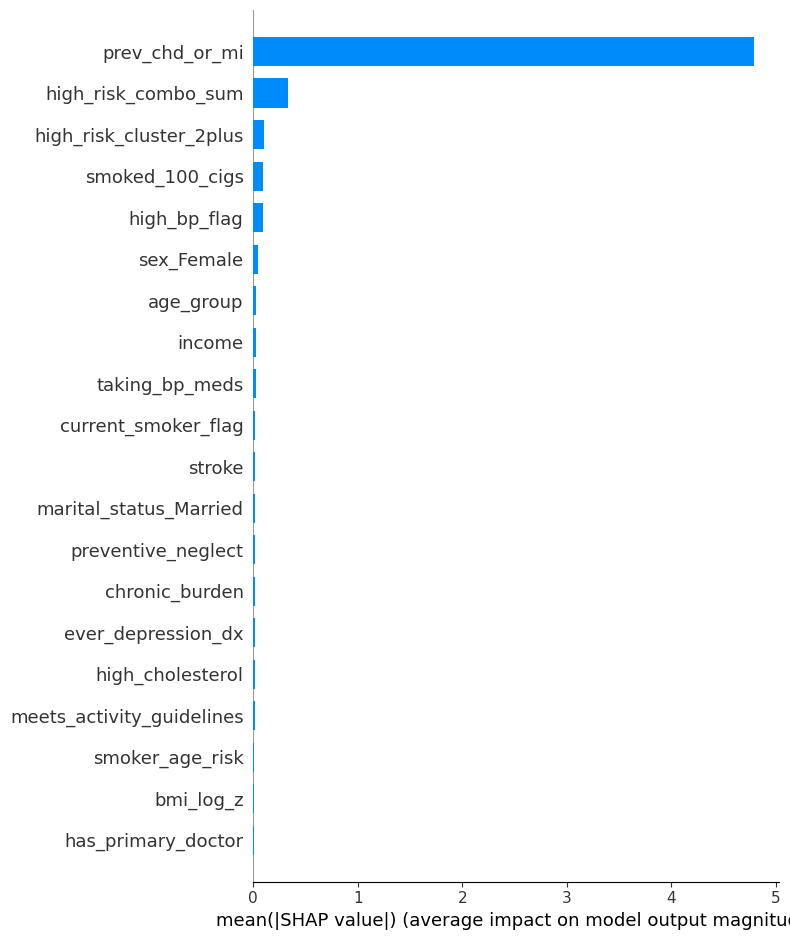

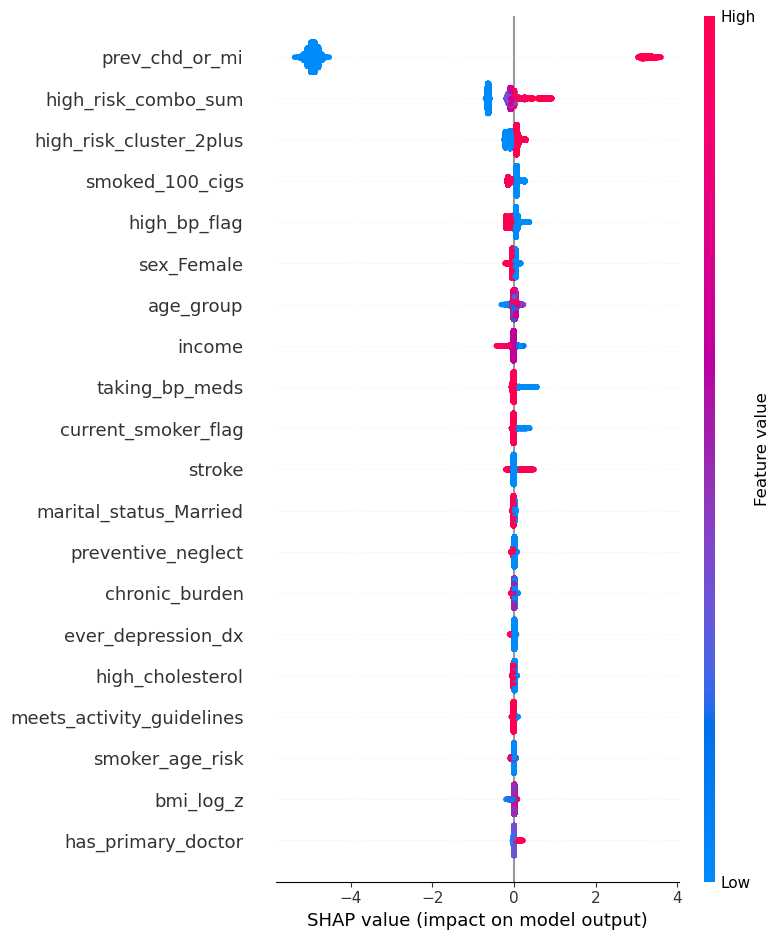

 SHAP plots saved to: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/reports/phase5


<Figure size 640x480 with 0 Axes>

In [88]:
shap_vals_eng, feat_names_eng = explain_shap(
    model_pipeline=pipe_eng,
    X_test=X_test,
    save_dir=report_dir,
    prefix="shap_with_engineering"
)

In [90]:
# import numpy as np
# import pandas as pd
# import json
# from pathlib import Path

N_TOP_FEATURES = 25
out_path = project_root / "data" / "derived" / "feature_list_final_curated.json"

#Computing mean SHAP value per feature 
mean_shap = np.abs(shap_vals_eng.values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": feat_names_eng,
    "mean_shap": mean_shap
}).sort_values(by="mean_shap", ascending=False)

top_features = shap_df["feature"].head(N_TOP_FEATURES).tolist()

out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, "w") as f:
    json.dump(top_features, f, indent=2)

print(f"Saved top {N_TOP_FEATURES} SHAP-curated features →", out_path)
top_features

✅ Saved top 25 SHAP-curated features → /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/feature_list_final_curated.json


['prev_chd_or_mi',
 'high_risk_combo_sum',
 'high_risk_cluster_2plus',
 'smoked_100_cigs',
 'high_bp_flag',
 'sex_Female',
 'age_group',
 'income',
 'taking_bp_meds',
 'current_smoker_flag',
 'stroke',
 'marital_status_Married',
 'preventive_neglect',
 'chronic_burden',
 'ever_depression_dx',
 'high_cholesterol',
 'meets_activity_guidelines',
 'smoker_age_risk',
 'bmi_log_z',
 'has_primary_doctor',
 'bmi',
 'mental_unhealthy_days_bin_code',
 'general_health_Good',
 'physical_unhealthy_days_bin_code',
 'race_ethnicity_White']

In [93]:
def get_shap_base_features_from_pipeline(preprocessor, shap_feature_names, numeric_features):
    """
    Maps SHAP OneHot feature names back to original column names.

    Args:
        preprocessor: fitted ColumnTransformer with "cat" and "num" transformers.
        shap_feature_names: List of SHAP feature names (after transform).
        numeric_features: List of numeric features used directly (not encoded).

    Returns:
        A deduplicated list of original feature names contributing to SHAP output.
    """
    # Get original categorical features
    cat_features = preprocessor.transformers_[0][2]
    ohe_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)

    # Create mapping: SHAP_OHE_name → base_column
    feature_map = dict(zip(ohe_feature_names, cat_features))

    # Re-map SHAP features
    base_features = []
    for f in shap_feature_names:
        if f in feature_map:
            base_features.append(feature_map[f])
        elif f in numeric_features:
            base_features.append(f)

    return sorted(set(base_features))


In [95]:
# Inputs from your pipeline
shap_feature_names = feat_names_eng  # from SHAP explainer
numeric_features = num_cols          # from your ColumnTransformer setup
top_25_features = top_features

base_features_from_shap = get_shap_base_features_from_pipeline(
    pipe_eng.named_steps["pre"],
    shap_feature_names=top_25_features,
    numeric_features=num_cols
)

print("Recovered base features from SHAP top 25:")
print(base_features_from_shap)


Recovered base features from SHAP top 25:
['age_group', 'bmi', 'bmi_log_z', 'chronic_burden', 'current_smoker_flag', 'ever_depression_dx', 'general_health', 'has_primary_doctor', 'high_bp_flag', 'high_cholesterol', 'high_risk_cluster_2plus', 'high_risk_combo_sum', 'income', 'meets_activity_guidelines', 'mental_unhealthy_days_bin_code', 'physical_unhealthy_days_bin_code', 'prev_chd_or_mi', 'preventive_neglect', 'sex', 'smoked_100_cigs', 'smoker_age_risk', 'stroke', 'taking_bp_meds']


In [97]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
# from xgboost import XGBClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# import matplotlib.pyplot as plt
# import pandas as pd
# import joblib

def train_and_compare_model(df, features, model_name, save_path, label_col="heart_attack"):
    """
    Train XGBoost model on selected features, evaluate, and plot ROC curve.

    Args:
        df: Pandas DataFrame containing data
        features: List of selected features
        model_name: Name for the model (used in plots/titles)
        save_path: Path to save the trained model
        label_col: Name of target label column (default: heart_attack)

    Returns:
        Trained pipeline, test set, predictions
    """
    X = df[features]
    y = df[label_col]

    # Identify categorical and numeric features
    cat_cols = [c for c in X.columns if X[c].nunique() <= 5 and X[c].dtype in [object, "category", bool, int]]
    num_cols = [c for c in X.columns if c not in cat_cols]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Preprocessor
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", "passthrough")
    ])

    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", num_pipe, num_cols)
    ])

    # Model
    clf = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                        use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)

    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", clf)
    ])

    # Train
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # Evaluate
    auc = roc_auc_score(y_test, y_proba)
    print(f"\nModel: {model_name}")
    print(f"AUROC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"{model_name} ROC Curve")
    plt.show()

    # Save
    joblib.dump(pipe, save_path)
    save_dir = save_path.parent
    joblib.dump(X_test, save_dir / "X_test25.joblib")
    joblib.dump(y_test, save_dir / "y_test25.joblib")
    print(f"✅ Saved model to: {save_path}")


    return pipe, X_test, y_test, y_pred



Model: xgb_top25_shap
AUROC: 0.9884
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     81461
           1       0.66      0.98      0.79      4690

    accuracy                           0.97     86151
   macro avg       0.83      0.97      0.89     86151
weighted avg       0.98      0.97      0.97     86151

Confusion Matrix:
 [[79082  2379]
 [  104  4586]]


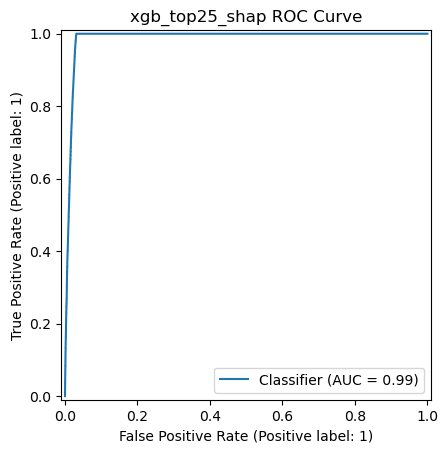

✅ Saved model to: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/models/xgb_top25_shap.joblib
bst model format is saved!


In [99]:
pipe_top25, X_test25, y_test25, y_pred25 = train_and_compare_model(
    df=df,
    features=base_features_from_shap,
    model_name="xgb_top25_shap",
    save_path=model_dir / "xgb_top25_shap.joblib"
)

# Saving the booster as native .bst for SageMaker deployment
from xgboost import Booster

# Extract the XGBClassifier from pipeline
xgb_model = pipe_top25.named_steps["clf"]
booster: Booster = xgb_model.get_booster()
booster.save_model(model_dir / "xgb_top25_shap.bst")
print("bst model format is saved!")

In [101]:
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import train_test_split
# import joblib

def compare_models_on_features(df, features, model_defs, model_dir):
    """
    Trains and compares multiple classifiers on a given feature subset.
    
    Args:
        df: full dataframe
        features: list of feature names to use
        model_defs: list of tuples (name, classifier_instance)
        model_dir: Path to save trained models
    
    Returns:
        results: List of (model_name, test_auc)
        trained_pipes: Dictionary of trained model pipelines
    """
    y = df["heart_attack"]
    X = df[features]

    # Split column types
    cat_cols = [c for c in X.columns if X[c].nunique() <= 5 and X[c].dtype in [int, "object", "category", bool]]
    num_cols = [c for c in X.columns if c not in cat_cols]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Preprocessor
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", "passthrough")
    ])
    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", num_pipe, num_cols)
    ])

    results = []
    trained_pipes = {}

    for name, clf in model_defs:
        pipe = Pipeline([
            ("pre", preprocessor),
            ("clf", clf)
        ])
        pipe.fit(X_train, y_train)
        trained_pipes[name] = pipe

        # Evaluation
        y_pred_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        results.append((name, auc))

        # Save model
        joblib.dump(pipe, model_dir / f"{name}.joblib")

        # Print summary
        print(f"✅ {name}: AUROC = {auc:.4f}")
        train_auc = roc_auc_score(y_train, pipe.predict_proba(X_train)[:, 1])
        print(f"   Train AUROC: {train_auc:.4f}")

    return results, trained_pipes

In [103]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)

def evaluate_multiple_models_with_subplots(model_dict, X_test, y_test):
    """
    Generates ROC, PR, Calibration, and Confusion Matrix subplots for multiple models.

    Args:
        model_dict: Dictionary like {"XGB": model_pipeline, "LogReg": ..., "LGBM": ...}
        X_test: Test features
        y_test: True test labels
    """
    fig, axes = plt.subplots(len(model_dict), 4, figsize=(20, 5 * len(model_dict)))

    for i, (name, model) in enumerate(model_dict.items()):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[i, 0])
        axes[i, 0].set_title(f"{name} - Confusion Matrix")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[i, 1].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
        axes[i, 1].plot([0, 1], [0, 1], "--", color="gray")
        axes[i, 1].set_title(f"{name} - ROC Curve")
        axes[i, 1].legend()

        # PR Curve
        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        axes[i, 2].plot(rec, prec, label=f"AP = {ap:.4f}")
        axes[i, 2].set_title(f"{name} - Precision-Recall Curve")
        axes[i, 2].legend()

        # Calibration Curve
        prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
        axes[i, 3].plot(prob_pred, prob_true, marker="o", label="Calibration")
        axes[i, 3].plot([0, 1], [0, 1], "--", color="gray", label="Perfect")
        axes[i, 3].set_title(f"{name} - Calibration Curve")
        axes[i, 3].legend()

    plt.tight_layout()
    plt.show()


✅ xgb: AUROC = 0.9884
   Train AUROC: 0.9895
✅ logreg: AUROC = 0.9882
   Train AUROC: 0.9883
[LightGBM] [Info] Number of positive: 17588, number of negative: 305478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 323066, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054441 -> initscore=-2.854661
[LightGBM] [Info] Start training from score -2.854661
✅ lgbm: AUROC = 0.9881
   Train AUROC: 0.9919


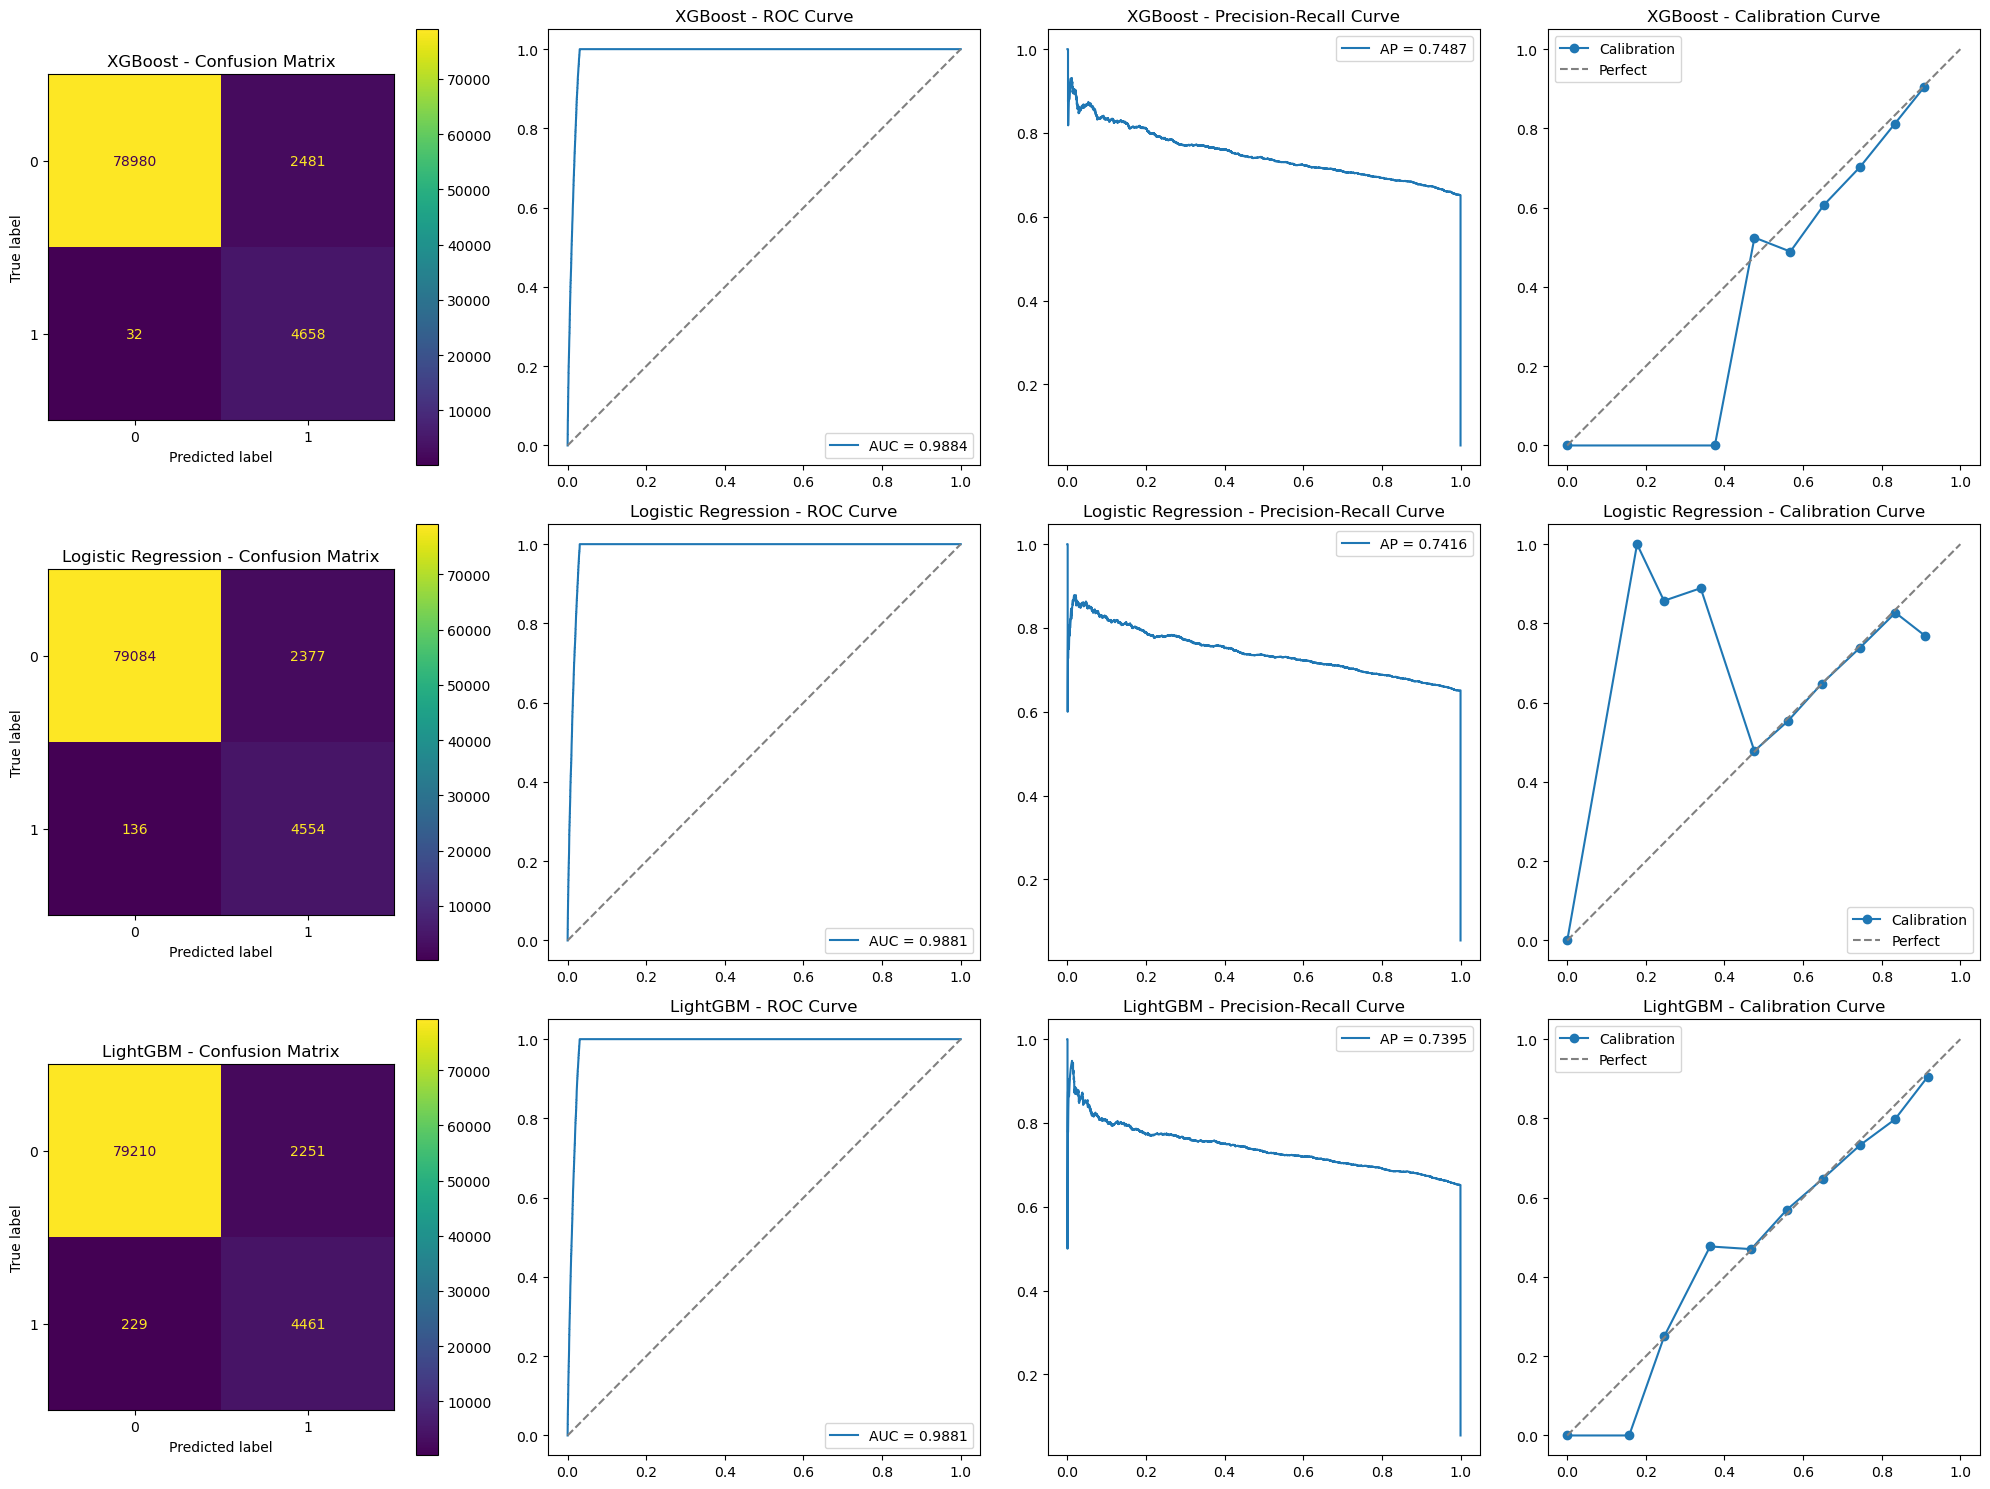

In [105]:
# Define the models
model_defs = [
    ("xgb", XGBClassifier(**best_params)),
    ("logreg", LogisticRegression(max_iter=500)),
    ("lgbm", LGBMClassifier())
]

# Run all comparisons
results, trained_pipes = compare_models_on_features(
    df,
    base_features_from_shap,  # Top 25 SHAP features
    model_defs,
    model_dir
)

# Unpack the trained pipelines
xgb_pipe     = trained_pipes["xgb"]
logreg_pipe  = trained_pipes["logreg"]
lightgbm_pipe= trained_pipes["lgbm"]

# Evaluate each with detailed metrics
evaluate_multiple_models_with_subplots(
    {
        "XGBoost": xgb_pipe,
        "Logistic Regression": logreg_pipe,
        "LightGBM": lightgbm_pipe},
    X_test,y_test)

In [ ]:
import json
import os

metadata = {
    "model_joblib_path": "models/xgb_top25_shap.joblib",
    "model_bst_path":    "models/xgb_top25_shap.bst",
    "X_test_path":       "models/X_test25.joblib",
    "y_test_path":       "models/y_test25.joblib",
    "y_pred_path":       "models/y_pred25.joblib"
}

os.makedirs("/opt/airflow/out", exist_ok=True)
with open("/opt/airflow/out/notebook_output_metadata.json", "w") as f:
    json.dump(metadata, f)

print("Model and evaluation paths saved for downstream MLflow registration.")
